In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda


In [3]:


# --- 0. 配置与数据构造 ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

TOTAL_SAMPLES = 8000
TRAIN_RATIO = 0.8
N_TRAIN = int(TOTAL_SAMPLES * TRAIN_RATIO)
N_TEST = TOTAL_SAMPLES - N_TRAIN
INPUT_DIM = 2
LR = 0.01
EPOCHS = 1000
BATCH_SIZE = 64

def create_synthetic_data(n_samples):
    """人工构造线性可分的二维数据集"""
    # 类别 0 的数据 (均值在 [-1, -1])
    X0 = torch.randn(n_samples // 2, INPUT_DIM) * 0.5 + torch.tensor([-1.0, -1.0])
    Y0 = torch.zeros(n_samples // 2, 1)

    # 类别 1 的数据 (均值在 [1, 1])
    X1 = torch.randn(n_samples - n_samples // 2, INPUT_DIM) * 0.5 + torch.tensor([1.0, 1.0])
    Y1 = torch.ones(n_samples - n_samples // 2, 1)

    X = torch.cat((X0, X1), dim=0).float()
    Y = torch.cat((Y0, Y1), dim=0).float()

    # 打乱数据
    perm = torch.randperm(n_samples)
    return X[perm], Y[perm]

# 构造并划分数据集
X_full, Y_full = create_synthetic_data(TOTAL_SAMPLES)
X_train, Y_train = X_full[:N_TRAIN], Y_full[:N_TRAIN]
X_test, Y_test = X_full[N_TRAIN:], Y_full[N_TRAIN:]

# 转换为 DataLoader 以便进行批量训练
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)



In [4]:
# --- 1. 从零实现 Logistic 回归 (仅 Tensor) ---

print("="*40)
print("1. 从零实现 Logistic 回归 (仅 Tensor)")
print("="*40)

# 1.1. 模型初始化 (权重 W 和 偏置 b)
W = torch.randn(INPUT_DIM, 1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# 1.2. 损失函数 (使用 nn.BCEWithLogitsLoss 辅助实现)
criterion_zero = torch.nn.BCEWithLogitsLoss()
loss_history_zero = []

def forward_zero(X):
    """前向传播：线性部分 X@W + b"""
    return X @ W + b

def predict_zero(logits):
    """预测：Sigmoid 后四舍五入得到 0 或 1"""
    probs = torch.sigmoid(logits)
    return (probs >= 0.5).float()

def calculate_accuracy(y_pred, y_true):
    """计算准确率"""
    correct = (y_pred == y_true).sum().item()
    return correct / len(y_true) * 100

# 1.3. 训练循环
for epoch in range(EPOCHS):
    for batch_X, batch_Y in train_loader:
        # 前向传播
        logits = forward_zero(batch_X)

        # 计算 Loss
        loss = criterion_zero(logits, batch_Y)

        # 反向传播 (自动计算梯度)
        loss.backward()

        # 参数更新 (使用 torch.no_grad() 避免将更新操作计入计算图)
        with torch.no_grad():
            W -= LR * W.grad
            b -= LR * b.grad

        # 清零梯度
        W.grad.zero_()
        b.grad.zero_()

    loss_history_zero.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

# 1.4. 结果分析 (任务 1)
with torch.no_grad():
    # 训练集评估
    train_logits_zero = forward_zero(X_train)
    train_pred_zero = predict_zero(train_logits_zero)
    train_acc_zero = calculate_accuracy(train_pred_zero, Y_train)
    
    # 测试集评估
    test_logits_zero = forward_zero(X_test)
    test_pred_zero = predict_zero(test_logits_zero)
    test_acc_zero = calculate_accuracy(test_pred_zero, Y_test)

print("-" * 30)
print(f"**任务 1 最终 Loss:** {loss_history_zero[-1]:.4f}")
print(f"**任务 1 训练集准确率:** {train_acc_zero:.2f}%")
print(f"**任务 1 测试集准确率:** {test_acc_zero:.2f}%")


# --- 2. 利用 torch.nn 实现 Logistic 回归 ---

print("\n" + "="*40)
print("2. 利用 torch.nn 实现 Logistic 回归")
print("="*40)

# 2.1. 模型定义 (使用 nn.Module)
class LogisticRegressionNN(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionNN, self).__init__()
        # nn.Linear 自动处理 W 和 b 的初始化
        self.linear = torch.nn.Linear(input_dim, 1)

    def forward(self, x):
        # 返回 logits (未经过 Sigmoid)
        return self.linear(x)

# 2.2. 初始化模型、损失函数和优化器
model_nn = LogisticRegressionNN(INPUT_DIM)
criterion_nn = torch.nn.BCEWithLogitsLoss()
optimizer_nn = torch.optim.SGD(model_nn.parameters(), lr=LR)
loss_history_nn = []

# 2.3. 训练循环
for epoch in range(EPOCHS):
    for batch_X, batch_Y in train_loader:
        # 清零梯度
        optimizer_nn.zero_grad()
        
        # 前向传播
        logits = model_nn(batch_X)

        # 计算 Loss
        loss = criterion_nn(logits, batch_Y)

        # 反向传播与参数更新
        loss.backward()
        optimizer_nn.step()

    loss_history_nn.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")




1. 从零实现 Logistic 回归 (仅 Tensor)
Epoch 100/1000, Loss: 0.0211
Epoch 200/1000, Loss: 0.0129
Epoch 300/1000, Loss: 0.0026
Epoch 400/1000, Loss: 0.0079
Epoch 500/1000, Loss: 0.0087
Epoch 600/1000, Loss: 0.0072
Epoch 700/1000, Loss: 0.0031
Epoch 800/1000, Loss: 0.0100
Epoch 900/1000, Loss: 0.0030
Epoch 1000/1000, Loss: 0.0049
------------------------------
**任务 1 最终 Loss:** 0.0049
**任务 1 训练集准确率:** 99.80%
**任务 1 测试集准确率:** 99.75%

2. 利用 torch.nn 实现 Logistic 回归
Epoch 100/1000, Loss: 0.0176
Epoch 200/1000, Loss: 0.0169
Epoch 300/1000, Loss: 0.0101
Epoch 400/1000, Loss: 0.0038
Epoch 500/1000, Loss: 0.0061
Epoch 600/1000, Loss: 0.0049
Epoch 700/1000, Loss: 0.0153
Epoch 800/1000, Loss: 0.0037
Epoch 900/1000, Loss: 0.0062
Epoch 1000/1000, Loss: 0.0009


In [5]:
# 2.4. 结果分析 (任务 2)
with torch.no_grad():
    # 训练集评估
    model_nn.eval()
    train_logits_nn = model_nn(X_train)
    train_pred_nn = predict_zero(train_logits_nn)
    train_acc_nn = calculate_accuracy(train_pred_nn, Y_train)
    
    # 测试集评估
    test_logits_nn = model_nn(X_test)
    test_pred_nn = predict_zero(test_logits_nn)
    test_acc_nn = calculate_accuracy(test_pred_nn, Y_test)

print("-" * 30)
print(f"**任务 2 最终 Loss:** {loss_history_nn[-1]:.4f}")
print(f"**任务 2 训练集准确率:** {train_acc_nn:.2f}%")
print(f"**任务 2 测试集准确率:** {test_acc_nn:.2f}%")


------------------------------
**任务 2 最终 Loss:** 0.0009
**任务 2 训练集准确率:** 99.80%
**任务 2 测试集准确率:** 99.69%


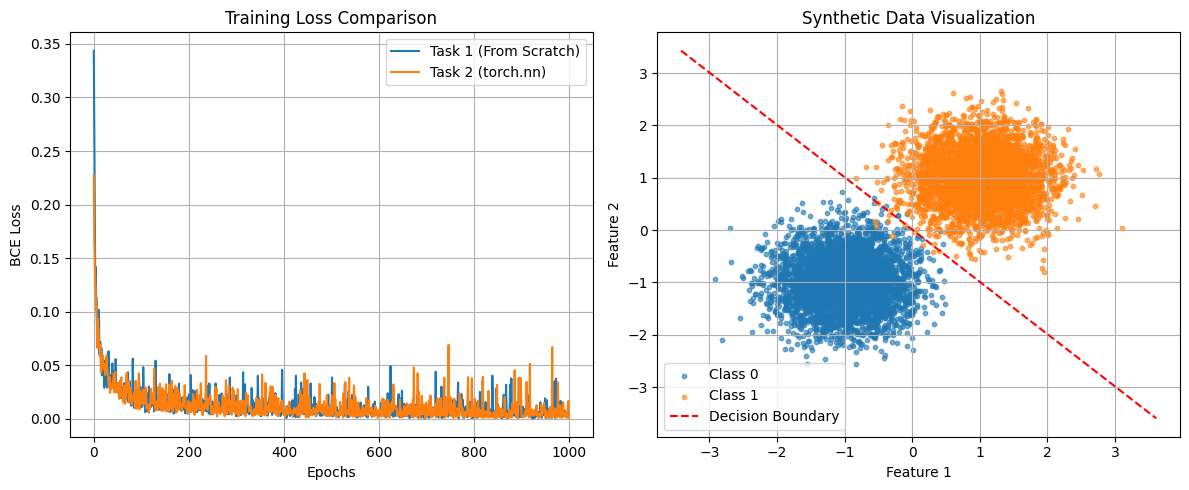


##################################################
## 总结对比分析
##################################################
| 实现方式 | 最终 Loss | 训练集准确率 | 测试集准确率 | 代码复杂度 |
| 任务 1 (从零实现) | 0.0049 | 99.80% | 99.75% | 高 (需手动管理梯度和更新) |
| 任务 2 (torch.nn) | 0.0009 | 99.80% | 99.69% | 低 (使用 nn.Linear 和 optim.SGD) |

**观察结论:**
1. **性能对比:** 两种实现方式在人工构造的线性可分数据集上均取得了极高的准确率，说明底层算法逻辑是一致的。
2. **代码效率:** 任务 2 利用 `torch.nn.Module`、`nn.Linear` 和 `optim.SGD`，代码更加简洁、模块化和可维护。
3. **收敛速度:** 两种实现方式的 Loss 曲线（左图）趋势相似，但在实际工程中，`torch.nn` 框架能更好地保证数值稳定性和收敛效率。


In [9]:

# --- 3. 可视化分析 ---
plt.figure(figsize=(12, 5))

# Loss 曲线
plt.subplot(1, 2, 1)
plt.plot(loss_history_zero, label='Task 1 (From Scratch)')
plt.plot(loss_history_nn, label='Task 2 (torch.nn)')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.grid(True)

# 数据集可视化
plt.subplot(1, 2, 2)
plt.scatter(X_full[:, 0][Y_full.squeeze() == 0], X_full[:, 1][Y_full.squeeze() == 0], s=10, label='Class 0', alpha=0.6)
plt.scatter(X_full[:, 0][Y_full.squeeze() == 1], X_full[:, 1][Y_full.squeeze() == 1], s=10, label='Class 1', alpha=0.6)
final_W = model_nn.linear.weight.data.numpy()
final_b = model_nn.linear.bias.data.numpy()

x1_min, x1_max = X_full[:, 0].min() - 0.5, X_full[:, 0].max() + 0.5
x1_plot = np.linspace(x1_min, x1_max, 100)

if final_W[0, 1] != 0: # 避免除以零
    x2_plot = (-final_W[0, 0] * x1_plot - final_b[0]) / final_W[0, 1]
    plt.plot(x1_plot, x2_plot, color='red', linestyle='--', label='Decision Boundary')
else: # 如果 w2 为 0，决策边界为垂直线 x1 = -b/w1
    plt.axvline(x=-final_b[0] / final_W[0, 0], color='red', linestyle='--', label='Decision Boundary')
    
plt.title('Synthetic Data Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- 4. 总结对比分析 (打印输出) ---
print("\n" + "#"*50)
print("## 总结对比分析")
print("#"*50)

summary_data = [
    ["实现方式", "最终 Loss", "训练集准确率", "测试集准确率", "代码复杂度"],
    ["任务 1 (从零实现)", f"{loss_history_zero[-1]:.4f}", f"{train_acc_zero:.2f}%", f"{test_acc_zero:.2f}%", "高 (需手动管理梯度和更新)"],
    ["任务 2 (torch.nn)", f"{loss_history_nn[-1]:.4f}", f"{train_acc_nn:.2f}%", f"{test_acc_nn:.2f}%", "低 (使用 nn.Linear 和 optim.SGD)"]
]

for row in summary_data:
    print(f"| {' | '.join(row)} |")

print("\n**观察结论:**")
print("1. **性能对比:** 两种实现方式在人工构造的线性可分数据集上均取得了极高的准确率，说明底层算法逻辑是一致的。")
print("2. **代码效率:** 任务 2 利用 `torch.nn.Module`、`nn.Linear` 和 `optim.SGD`，代码更加简洁、模块化和可维护。")
print("3. **收敛速度:** 两种实现方式的 Loss 曲线（左图）趋势相似，但在实际工程中，`torch.nn` 框架能更好地保证数值稳定性和收敛效率。")